https://www.science.org/doi/10.1126/science.1127647

https://github.com/L1aoXingyu/pytorch-beginner/blob/9c86be785c7c318a09cf29112dd1f1a58613239b/08-AutoEncoder/conv_autoencoder.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from pathlib import Path
from torch.utils.data import TensorDataset, DataLoader
from lib.modules import (
    evaluate_loop, 
    pad_for_windowing,
    window_session,
    optimization_loop
)
from tqdm import tqdm

In [37]:
WINSIZE = 101
DEVICE = 'cpu'
RAW_DIR = Path('/home/mmazeem/datasets/eating_raw/')

In [5]:
recordings = []
for rec_dir in RAW_DIR.iterdir():
    recordings.append(rec_dir)
    print(rec_dir.name)

andrew-2023-11-01_15_49_48
andrew-2023-10-26_15_32_20
data-11-1-23


In [6]:
session_dir = recordings[0]
acceleration = pd.read_csv(session_dir / 'acceleration.csv',skiprows=1)
acceleration_start_time_seconds = float(pd.read_csv(session_dir / 'acceleration.csv',nrows=1,header=None).iloc[0,0].split()[-1])/1000
acceleration.timestamp = ((acceleration.timestamp - acceleration.timestamp[0])*1e-9)+acceleration_start_time_seconds
acceleration = acceleration.dropna()

In [34]:
Xtr = torch.Tensor(acceleration[['x','y','z']].values)
Xtr = (Xtr - Xtr.mean()) / Xtr.std()
Xtr = (Xtr - Xtr.mean()) / Xtr.std()

Xtr = pad_for_windowing(Xtr, WINSIZE)
Xtr = window_session(Xtr, WINSIZE)
trainloader = DataLoader(TensorDataset(Xtr), batch_size=64, shuffle=True)

In [38]:
# First: Autoencoder reduces input to 3 dimensions

class Autoencoder(nn.Module):
    def __init__(self, winsize):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(winsize*3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, winsize*3),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder(winsize=WINSIZE).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

  0%|          | 0/3 [00:00<?, ?it/s]

/home/mmazeem/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/mmazeem/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 2: Train Loss: 0.99144: 100%|██████████| 3/3 [03:45<00:00, 75.08s/it]


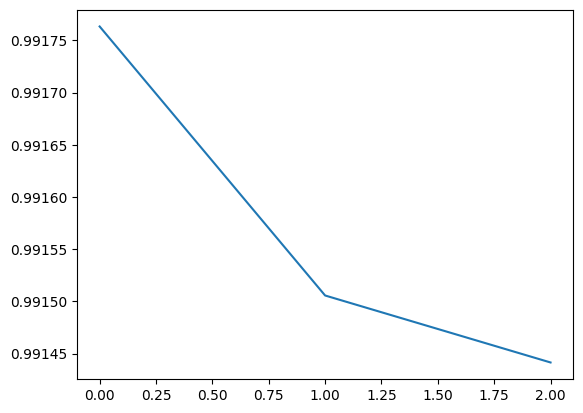

In [39]:
losses = []
pbar = tqdm(range(3))
for epoch in pbar:
    lossi = 0
    for X in trainloader:
        X = X[0].to(DEVICE)

        logits = model(X)
        loss = criterion(logits, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossi += loss.item()

    losses.append(lossi/len(trainloader))
    pbar.set_description(f'Epoch {epoch}: Train Loss: {losses[-1]:.5}')

plt.plot(losses)